## model: dzien roboczy- swieto, godzinowo

### getting data

In [1]:
import pandas as pd
from datetime import date
import datetime
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt


end_dt = '2019-03-31'
# #2 months:
# start_dt = '2019-02-01'

#6 months:
# start_dt = '2018-10-01'

# 12 months:
# start_dt = '2018-04-01'

# #24 months:
# start_dt = '2017-04-01'

# # #60 months:
start_dt = '2014-04-01'

weekdays =['Pon', 'Wt', 'Sr', 'Czw', 'Pt', 'Sb', 'Nd']

def dzienTyg(dzienNum):
    if dzienNum == 0:
        return 'Pon'
    elif dzienNum == 1:
        return 'Wt'
    elif dzienNum == 2:
        return 'Sr'
    elif dzienNum == 3:
        return 'Czw'
    elif dzienNum == 4:
        return 'Pt'
    elif dzienNum == 5:
        return 'Sb'
    elif dzienNum == 6:
        return 'Nd'
    else:
        return 'Blad'
def date_fromisofromat(dt):
    y = int(dt[0: 4])
    m = int(dt[5: 7])
    d = int(dt[8:10])
    return date(y,m,d)

def combineData(start, end):
    startDt = date_fromisofromat(start)
    endDt   = date_fromisofromat(end)
    d = datetime.timedelta(days=1)
    m = relativedelta(months=+1)

    in_table = pd.read_csv(filepath_or_buffer= '../Data/20100301-20100331.csv', 
                       sep=';', 
                       engine='python')
    in_table= in_table.iloc[0:0] #drop all rows, leave columns

    while(startDt <= endDt):
        fileName = str(startDt).replace('-','') + '-' + str(startDt + m - d).replace('-','') + '.csv'
        in_table1 = pd.read_csv(filepath_or_buffer= '../Data/' +fileName, 
                           sep=';', 
                           engine='python')
        in_table = in_table.append(in_table1,ignore_index=True)
        startDt = startDt + relativedelta(months=+1)

    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].apply(lambda x: x.replace(',','.'))
    in_table['Krajowe zapotrzebowanie na moc'] = in_table['Krajowe zapotrzebowanie na moc'].astype(float)
    in_table['Rok']     = in_table['Data'].apply(lambda x: x[0: 4]).astype(int)
    in_table['Miesiac'] = in_table['Data'].apply(lambda x: x[5: 7]).astype(int)
    in_table['Dzien']   = in_table['Data'].apply(lambda x: x[8:10]).astype(int)
    # in_table['Godz_mies']=(in_table['Dzien']-1)*24 +in_table['Godzina']
    return in_table
#     plt.show()
# Data, Godzina, Krajowe zapotrzebowanie na moc, Sumaryczna generacja JWCD, 
# Generacja PI, Generacja IRZ, Sumaryczna generacja nJWCD, 
# Krajowe saldo wymiany międzysystemowej równoległej, 
# Krajowe saldo wymiany międzysystemowej nierównoległej, 

dataAll = combineData(start_dt, end_dt)
dataAll = dataAll.loc[dataAll['Godzina'] != '2A']

dataAll['Godzina'] = dataAll['Godzina'].apply(
    lambda x: (int(str(x)))
)
dataAll['weekDayNum'] = dataAll['Data'].apply(
    lambda x: (date_fromisofromat(x).weekday())
)
dataAll['weekDay'] = dataAll['Data'].apply(
    lambda x: dzienTyg(date_fromisofromat(x).weekday())
)
dataAll['DataGodz'] = pd.to_datetime(dataAll['Data']) 

dataAll['DataGodz'] = dataAll['DataGodz'] + dataAll['Godzina'].apply(
    lambda x: relativedelta(hours=x)
)
    
modelData = dataAll[['Krajowe zapotrzebowanie na moc']]

#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz']] 
modelData2.set_index('DataGodz')
modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

modelData2

D:\Programy\anaconda\lib\site-packages\pandas\core\arrays\datetimelike.py:1345: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


,Krajowe zapotrzebowanie na moc,DataGodz
DataGodz,,
2014-04-01 01:00:00,15820.063,2014-04-01 01:00:00
2014-04-01 02:00:00,15253.238,2014-04-01 02:00:00
2014-04-01 03:00:00,14943.475,2014-04-01 03:00:00
2014-04-01 04:00:00,14880.913,2014-04-01 04:00:00
2014-04-01 05:00:00,15148.463,2014-04-01 05:00:00
...,...,...
2019-03-31 20:00:00,18097.938,2019-03-31 20:00:00
2019-03-31 21:00:00,18774.000,2019-03-31 21:00:00
2019-03-31 22:00:00,17979.813,2019-03-31 22:00:00


In [2]:
dataAll
#For Arima:
modelData2 = dataAll[['Krajowe zapotrzebowanie na moc',
                      'DataGodz','weekDay']] 
# modelData2.set_index('DataGodz')
# modelData2.index = pd.DatetimeIndex(modelData2['DataGodz'])#.to_period('H')

In [3]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
def create_model(dane, sezon, maxiter = 20):
    start = datetime.now()

    #auto ARIMA
    m = auto_arima(dane, 
           seasonal = True, 
           m=sezon, 
           maxiter = maxiter,
           trace = True)#.summary()
    print('autoARIMA time: ' + str(datetime.now() - start))
    order = m.get_params()['order']
    seasonal_order = m.get_params()['seasonal_order']
    print(order)
    print(seasonal_order)
    #SARIMAX
    fit_start =  datetime.now()
    model = SARIMAX(dane, order=order, seasonal_order=seasonal_order, initialization='approximate_diffuse')
    model_fit = model.fit() 
    
    print('fit time = ' + str(datetime.now() - fit_start))
    return model_fit

#### petla godzinowa

In [4]:
models_num = 24
my_models = [None] * models_num

In [5]:
# modelData2.where(modelData2['DataGodz'].hour==2)
modelData2[dataAll['Godzina']==0]['Krajowe zapotrzebowanie na moc']

Series([], Name: Krajowe zapotrzebowanie na moc, dtype: float64)

In [6]:
starttime = datetime.now()
print('start petli: ' +str(starttime))
for i in range(models_num):
    print('##### startuje dopasowanie modelu dla godziny: ' + str(i))
    my_models[i] = create_model(
        modelData2[dataAll['Godzina'] % 24 ==i %24]['Krajowe zapotrzebowanie na moc']
        ,7
    )
    print('##### Koniec dopasowania modelu dla godziny: ' + str(i))
    print('#####')

start petli: 2021-04-13 12:14:47.323228
##### startuje dopasowanie modelu dla godziny: 0
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30902.200, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29210.978, Time=1.55 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=30038.497, Time=1.37 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30900.201, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=30902.778, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=28939.231, Time=1.76 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=29594.783, Time=2.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=29538.251, Time=1.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=28945.821, Time=1.56 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=29282.646, Time=2.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=1.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=29038.190, Time=1.84 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=3.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=28937.525, Time=1.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7]             : AIC=29209.090, Time=0.55 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7]             : AIC=inf, Time=1.45 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7]             : AIC=28974.728, Time=0.94 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=28939.729, Time=0.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7]             : AIC=29280.603, Time=1.74 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=1.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=29032.920, Time=1.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,0)[7]             : AIC=inf, Time=1.60 sec

Best model:  ARIMA(1,1,0)(2,0,0)[7]          
Total fit time: 32.117 seconds
autoARIMA time: 0:00:32.202392
(1, 1, 0)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:01.495974
##### Koniec dopasowania modelu dla godziny: 0
#####
##### startuje dopasowanie modelu dla godziny: 1
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.87 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30618.722, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28849.129, Time=1.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29743.528, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30616.722, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=30617.550, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=28554.944, Time=2.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.86 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=28562.193, Time=1.55 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=28876.143, Time=2.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=28759.792, Time=2.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.47 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=28556.572, Time=1.05 sec

Best model:  ARIMA(1,1,0)(2,0,0)[7] intercept
Total fit time: 23.745 seconds
autoARIMA time: 0:00:23.785898
(1, 1, 0)
(2, 0, 0, 7)
fit time = 0:00:01.109754
##### Koniec dopasowania modelu dla godziny: 1
#####
##### startuje dopasowanie modelu dla godziny: 2
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30312.712, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28570.127, Time=0.99 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29451.135, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30310.713, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=30306.102, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=28803.619, Time=1.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=28777.061, Time=1.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=29452.755, Time=0.92 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=28957.290, Time=1.94 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=28568.160, Time=1.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=28290.237, Time=1.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=28208.700, Time=1.90 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=28163.295, Time=1.34 sec
 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=29451.937, Time=0.78 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,2)[7] intercept   : AIC=28802.115, Time=2.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(0,0,2)[7] intercept   : AIC=29066.361, Time=1.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=28847.425, Time=2.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=28746.071, Time=1.42 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.59 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7]             : AIC=28054.830, Time=0.56 sec
 ARIMA(0,1,0)(0,0,1)[7]             : AIC=29449.937, Time=0.39 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=28566.278, Time=0.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7]             : AIC=28057.288, Time=0.99 sec
 ARIMA(0,1,0)(1,0,2)[7]             : AIC=28054.309, Time=0.64 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(0,0,2)[7]             : AIC=29065.498, Time=0.81 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,2)[7]             : AIC=28055.920, Time=1.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,2)[7]             : AIC=28379.290, Time=1.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,2)[7]             : AIC=28265.114, Time=1.81 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,2)[7]             : AIC=inf, Time=2.11 sec

Best model:  ARIMA(0,1,0)(1,0,2)[7]          
Total fit time: 36.588 seconds
autoARIMA time: 0:00:36.689576
(0, 1, 0)
(1, 0, 2, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.757463
##### Koniec dopasowania modelu dla godziny: 2
#####
##### startuje dopasowanie modelu dla godziny: 3
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=27967.749, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30235.371, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28410.032, Time=1.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29320.086, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30233.371, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=28843.768, Time=1.81 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=2.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=27998.154, Time=3.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=27965.081, Time=3.45 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=28620.853, Time=3.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.82 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=27957.432, Time=2.81 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=28615.948, Time=2.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=27951.850, Time=1.63 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=28846.376, Time=1.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=1.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=27959.418, Time=2.50 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=29558.250, Time=0.92 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=2.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.62 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.75 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.02 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(1,0,1)[7] intercept   : AIC=inf, Time=2.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.84 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(1,0,1)[7] intercept   : AIC=inf, Time=1.77 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.67 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,3)(1,0,1)[7] intercept   : AIC=28358.263, Time=2.41 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(1,0,1)[7]             : AIC=inf, Time=1.40 sec

Best model:  ARIMA(1,1,2)(1,0,1)[7] intercept
Total fit time: 55.794 seconds
autoARIMA time: 0:00:55.900411
(1, 1, 2)
(1, 0, 1, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:03.336252
##### Koniec dopasowania modelu dla godziny: 3
#####
##### startuje dopasowanie modelu dla godziny: 4
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=27962.379, Time=1.96 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30317.288, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28404.819, Time=1.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29333.653, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30315.289, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=28843.299, Time=1.94 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=28314.298, Time=1.70 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=27972.450, Time=3.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=27970.076, Time=3.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=29572.197, Time=1.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=28604.342, Time=2.78 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=2.92 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.44 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.64 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.71 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(1,0,1)[7] intercept   : AIC=28378.530, Time=2.55 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.45 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(1,0,1)[7] intercept   : AIC=inf, Time=2.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,3)(1,0,1)[7] intercept   : AIC=28323.580, Time=2.53 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7]             : AIC=inf, Time=1.62 sec

Best model:  ARIMA(2,1,2)(1,0,1)[7] intercept
Total fit time: 42.324 seconds
autoARIMA time: 0:00:42.395018
(2, 1, 2)
(1, 0, 1, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:04.368967
##### Koniec dopasowania modelu dla godziny: 4
#####
##### startuje dopasowanie modelu dla godziny: 5
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30428.126, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28430.034, Time=1.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29346.648, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30426.127, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=30377.688, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=29432.234, Time=0.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=28471.035, Time=0.74 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=28310.837, Time=1.33 sec
 ARIMA(2,1,0)(0,0,0)[7] intercept   : AIC=29937.864, Time=0.24 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.84 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(0,0,1)[7] intercept   : AIC=29146.437, Time=1.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.49 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,0)(1,0,0)[7] intercept   : AIC=28382.437, Time=1.59 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=28810.109, Time=1.64 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.52 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(1,0,0)[7] intercept   : AIC=28596.030, Time=1.73 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,0)[7]             : AIC=28308.939, Time=0.70 sec
 ARIMA(2,1,0)(0,0,0)[7]             : AIC=29935.863, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7]             : AIC=inf, Time=1.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,1)[7]             : AIC=inf, Time=1.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(0,0,1)[7]             : AIC=29144.439, Time=0.67 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,1)[7]             : AIC=inf, Time=1.84 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7]             : AIC=28428.257, Time=0.53 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,0)(1,0,0)[7]             : AIC=28380.323, Time=0.85 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(1,0,0)[7]             : AIC=28807.084, Time=0.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7]             : AIC=inf, Time=1.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(3,1,1)(1,0,0)[7]             : AIC=28635.386, Time=0.99 sec

Best model:  ARIMA(2,1,0)(1,0,0)[7]          
Total fit time: 38.666 seconds
autoARIMA time: 0:00:38.756458
(2, 1, 0)
(1, 0, 0, 7)
fit time = 0:00:01.123960
##### Koniec dopasowania modelu dla godziny: 5
#####
##### startuje dopasowanie modelu dla godziny: 6
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=28373.721, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=30954.041, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28793.986, Time=1.47 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=29781.841, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=30952.042, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=29273.101, Time=1.96 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=1.84 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=28371.918, Time=2.99 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=3.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.98 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=28364.922, Time=3.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=29027.987, Time=3.00 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=28354.266, Time=3.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(0,0,2)[7] intercept   : AIC=29027.545, Time=2.44 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.75 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.48 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,2)(0,0,1)[7] intercept   : AIC=29277.364, Time=1.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,1)[7] intercept   : AIC=inf, Time=2.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(1,0,2)[7] intercept   : AIC=inf, Time=2.50 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(1,0,2)[7] intercept   : AIC=inf, Time=4.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.40 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,3)(1,0,2)[7] intercept   : AIC=inf, Time=3.47 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=inf, Time=2.80 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(1,0,2)[7] intercept   : AIC=28909.953, Time=4.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(1,0,2)[7]             : AIC=inf, Time=2.31 sec

Best model:  ARIMA(1,1,2)(1,0,2)[7] intercept
Total fit time: 63.197 seconds
autoARIMA time: 0:01:03.333846
(1, 1, 2)
(1, 0, 2, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


fit time = 0:00:07.185874
##### Koniec dopasowania modelu dla godziny: 6
#####
##### startuje dopasowanie modelu dla godziny: 7
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.21 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33098.962, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=30898.058, Time=1.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32074.518, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33096.964, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33100.888, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=30606.537, Time=1.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.02 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.39 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.45 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=30744.457, Time=2.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=30604.781, Time=1.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7]             : AIC=30896.139, Time=0.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7]             : AIC=inf, Time=1.80 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7]             : AIC=inf, Time=1.02 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=30613.568, Time=0.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7]             : AIC=inf, Time=1.53 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=2.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=30739.342, Time=1.51 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,0)[7]             : AIC=inf, Time=2.12 sec

Best model:  ARIMA(1,1,0)(2,0,0)[7]          
Total fit time: 34.441 seconds
autoARIMA time: 0:00:34.526445
(1, 1, 0)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:01.432252
##### Koniec dopasowania modelu dla godziny: 7
#####
##### startuje dopasowanie modelu dla godziny: 8
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.39 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=34130.440, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32603.190, Time=0.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.39 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=34128.442, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=34121.310, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=31777.445, Time=1.73 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.45 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=1.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=32291.221, Time=1.74 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,0)[7] intercept   : AIC=32516.890, Time=2.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=31774.983, Time=1.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7]             : AIC=32601.194, Time=0.76 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7]             : AIC=inf, Time=1.75 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=31667.473, Time=0.86 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=31976.671, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7]             : AIC=inf, Time=1.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7]             : AIC=inf, Time=0.78 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=32179.827, Time=1.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=2.22 sec

Best model:  ARIMA(0,1,0)(2,0,0)[7]          
Total fit time: 30.924 seconds
autoARIMA time: 0:00:31.004952
(0, 1, 0)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.350250
##### Koniec dopasowania modelu dla godziny: 8
#####
##### startuje dopasowanie modelu dla godziny: 9
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=34260.601, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32779.425, Time=1.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=33315.814, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=34258.602, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=34227.418, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.77 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.46 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=33240.119, Time=0.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.80 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=32226.872, Time=0.71 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.54 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.90 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=33280.465, Time=0.76 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.86 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=32375.995, Time=0.93 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=32225.112, Time=0.18 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=31925.629, Time=0.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7]             : AIC=inf, Time=1.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7]             : AIC=inf, Time=0.77 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=inf, Time=1.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=31791.368, Time=1.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=inf, Time=0.82 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7]             : AIC=inf, Time=1.58 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7]             : AIC=inf, Time=1.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=2.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,2)(2,0,0)[7]             : AIC=32276.219, Time=1.46 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,0)[7]             : AIC=inf, Time=1.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=31793.830, Time=1.75 sec

Best model:  ARIMA(0,1,1)(2,0,0)[7]          
Total fit time: 35.485 seconds
autoARIMA time: 0:00:35.612197
(0, 1, 1)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:02.057454
##### Koniec dopasowania modelu dla godziny: 9
#####
##### startuje dopasowanie modelu dla godziny: 10
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.16 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=34000.823, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32542.451, Time=1.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=33044.983, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33998.825, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33945.673, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=32417.051, Time=1.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=31824.150, Time=1.44 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=32101.100, Time=0.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.80 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=31819.323, Time=1.74 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=32196.446, Time=1.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.35 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=1.82 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=32062.293, Time=2.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=31816.955, Time=1.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=32195.101, Time=0.79 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7]             : AIC=inf, Time=1.75 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7]             : AIC=inf, Time=1.10 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=31814.272, Time=0.40 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=32099.587, Time=0.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7]             : AIC=inf, Time=1.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7]             : AIC=inf, Time=0.80 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=32415.047, Time=1.41 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=2.18 sec

Best model:  ARIMA(0,1,0)(2,0,0)[7]          
Total fit time: 39.286 seconds
autoARIMA time: 0:00:39.387888
(0, 1, 0)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.318226
##### Koniec dopasowania modelu dla godziny: 10
#####
##### startuje dopasowanie modelu dla godziny: 11
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33654.076, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32201.539, Time=0.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32731.515, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33652.077, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33591.739, Time=0.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.93 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=32680.396, Time=0.90 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.35 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=31896.949, Time=0.73 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.50 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.70 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(0,0,1)[7] intercept   : AIC=32770.506, Time=0.75 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=32004.140, Time=1.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=31895.387, Time=0.20 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=31615.980, Time=0.35 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7]             : AIC=inf, Time=1.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7]             : AIC=inf, Time=0.73 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=inf, Time=1.52 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=31486.178, Time=1.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=32002.262, Time=0.75 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7]             : AIC=inf, Time=1.65 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7]             : AIC=inf, Time=1.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=1.85 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,2)(2,0,0)[7]             : AIC=inf, Time=1.67 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,0)[7]             : AIC=inf, Time=1.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=31488.486, Time=1.70 sec

Best model:  ARIMA(0,1,1)(2,0,0)[7]          
Total fit time: 35.370 seconds
autoARIMA time: 0:00:35.472268
(0, 1, 1)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:02.110631
##### Koniec dopasowania modelu dla godziny: 11
#####
##### startuje dopasowanie modelu dla godziny: 12
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33705.332, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32253.095, Time=1.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32781.070, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33703.333, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33649.955, Time=0.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.81 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=32749.472, Time=0.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=31974.814, Time=0.76 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=31702.964, Time=1.92 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.76 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=2.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=31621.623, Time=1.54 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=32082.490, Time=1.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.64 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=1.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=1.78 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=2.58 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=31621.820, Time=1.21 sec

Best model:  ARIMA(0,1,1)(2,0,0)[7] intercept
Total fit time: 31.021 seconds
autoARIMA time: 0:00:31.095015
(0, 1, 1)
(2, 0, 0, 7)
fit time = 0:00:01.576053
##### Koniec dopasowania modelu dla godziny: 12
#####
##### startuje dopasowanie modelu dla godziny: 13
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.07 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33705.789, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32210.832, Time=0.94 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32737.129, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33703.790, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33666.244, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=31618.009, Time=1.71 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.33 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=31702.132, Time=1.51 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=31593.755, Time=1.63 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=32093.744, Time=1.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=1.88 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=31835.135, Time=2.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=31592.054, Time=1.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=32091.564, Time=0.80 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7]             : AIC=inf, Time=1.65 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7]             : AIC=inf, Time=2.20 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=31691.743, Time=0.40 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=1.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(2,0,0)[7]             : AIC=inf, Time=1.69 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=31616.145, Time=1.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,0)[7]             : AIC=inf, Time=1.69 sec

Best model:  ARIMA(0,1,1)(2,0,0)[7]          
Total fit time: 38.591 seconds
autoARIMA time: 0:00:38.688312
(0, 1, 1)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:01.342951
##### Koniec dopasowania modelu dla godziny: 13
#####
##### startuje dopasowanie modelu dla godziny: 14
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33705.065, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32094.338, Time=0.96 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32844.236, Time=0.97 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33703.066, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33676.662, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.96 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=32771.812, Time=0.99 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=31956.550, Time=0.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=31687.030, Time=1.58 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.87 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=31561.302, Time=1.78 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=32078.954, Time=1.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=inf, Time=2.00 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.53 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,2)(2,0,0)[7] intercept   : AIC=31736.337, Time=2.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,0)[7] intercept   : AIC=31800.270, Time=2.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=31560.558, Time=1.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=32076.822, Time=0.83 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,1)[7]             : AIC=inf, Time=1.63 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,1)[7]             : AIC=inf, Time=1.41 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=31674.559, Time=0.49 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=1.86 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,2)(2,0,0)[7]             : AIC=31845.936, Time=1.96 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=inf, Time=1.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,0)[7]             : AIC=inf, Time=1.76 sec

Best model:  ARIMA(0,1,1)(2,0,0)[7]          
Total fit time: 42.158 seconds
autoARIMA time: 0:00:42.263824
(0, 1, 1)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:01.452028
##### Koniec dopasowania modelu dla godziny: 14
#####
##### startuje dopasowanie modelu dla godziny: 15
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33670.460, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=31889.473, Time=1.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32808.859, Time=1.18 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33668.461, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33653.994, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=32747.134, Time=0.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=31907.353, Time=0.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=32113.453, Time=1.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=32031.738, Time=1.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.46 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(1,1,0)(1,0,0)[7]             : AIC=31889.776, Time=0.75 sec

Best model:  ARIMA(1,1,0)(1,0,0)[7] intercept
Total fit time: 17.615 seconds
autoARIMA time: 0:00:17.643492
(1, 1, 0)
(1, 0, 0, 7)
fit time = 0:00:01.427544
##### Koniec dopasowania modelu dla godziny: 15
#####
##### startuje dopasowanie modelu dla godziny: 16
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33725.393, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=32089.306, Time=1.02 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32887.296, Time=1.05 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33723.395, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33709.965, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.77 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=32799.248, Time=0.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=31952.240, Time=0.71 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=31676.730, Time=1.47 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.83 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.91 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=32141.772, Time=1.88 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.51 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=31671.323, Time=0.40 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=31950.621, Time=0.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7]             : AIC=inf, Time=1.19 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7]             : AIC=inf, Time=0.80 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=inf, Time=1.42 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=32139.653, Time=1.47 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=1.79 sec

Best model:  ARIMA(0,1,0)(2,0,0)[7]          
Total fit time: 28.071 seconds
autoARIMA time: 0:00:28.142973
(0, 1, 0)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.397265
##### Koniec dopasowania modelu dla godziny: 16
#####
##### startuje dopasowanie modelu dla godziny: 17
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33608.273, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=31829.430, Time=1.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32782.666, Time=1.09 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33606.275, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33594.762, Time=0.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=32683.202, Time=1.00 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=31858.009, Time=0.70 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=32113.455, Time=1.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=31996.371, Time=0.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=inf, Time=1.64 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7]             : AIC=31827.469, Time=0.74 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=33592.762, Time=0.07 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=inf, Time=1.44 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7]             : AIC=inf, Time=1.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7]             : AIC=32681.205, Time=0.73 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7]             : AIC=inf, Time=1.70 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=31856.361, Time=0.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,0)[7]             : AIC=32111.614, Time=0.94 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7]             : AIC=inf, Time=1.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=31989.460, Time=0.70 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(1,0,0)[7]             : AIC=inf, Time=1.15 sec

Best model:  ARIMA(1,1,0)(1,0,0)[7]          
Total fit time: 26.685 seconds
autoARIMA time: 0:00:26.743033
(1, 1, 0)
(1, 0, 0, 7)
fit time = 0:00:01.186270
##### Koniec dopasowania modelu dla godziny: 17
#####
##### startuje dopasowanie modelu dla godziny: 18
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.33 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33384.477, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=31689.333, Time=1.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32583.790, Time=1.16 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33382.478, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=33375.751, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.15 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=32481.591, Time=0.96 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=31692.884, Time=0.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,0)[7] intercept   : AIC=31937.506, Time=1.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7] intercept   : AIC=32091.927, Time=1.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=31862.436, Time=0.98 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(1,0,0)[7] intercept   : AIC=31974.438, Time=1.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7]             : AIC=31687.429, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=33373.751, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=inf, Time=1.55 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7]             : AIC=inf, Time=1.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7]             : AIC=32479.594, Time=0.67 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7]             : AIC=inf, Time=1.66 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=31691.170, Time=0.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,0)(1,0,0)[7]             : AIC=31935.508, Time=1.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,0)[7]             : AIC=inf, Time=1.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(1,0,0)[7]             : AIC=31863.069, Time=0.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


 ARIMA(2,1,1)(1,0,0)[7]             : AIC=31972.977, Time=1.24 sec

Best model:  ARIMA(1,1,0)(1,0,0)[7]          
Total fit time: 27.071 seconds
autoARIMA time: 0:00:27.137213
(1, 1, 0)
(1, 0, 0, 7)
fit time = 0:00:01.383981
##### Koniec dopasowania modelu dla godziny: 18
#####
##### startuje dopasowanie modelu dla godziny: 19
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=30891.096, Time=2.11 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=33075.712, Time=0.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=31469.220, Time=1.02 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32233.819, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=33073.714, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=31774.525, Time=2.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=31238.585, Time=2.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=30922.395, Time=3.45 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=30909.859, Time=3.86 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,0)[7] intercept   : AIC=inf, Time=1.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=inf, Time=3.65 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=31119.812, Time=3.65 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=inf, Time=3.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.83 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.70 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.32 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,3)(1,0,1)[7] intercept   : AIC=31322.120, Time=2.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=1.55 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,3)(1,0,1)[7] intercept   : AIC=inf, Time=2.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(1,0,1)[7] intercept   : AIC=inf, Time=2.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,3)(1,0,1)[7] intercept   : AIC=31313.825, Time=2.47 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7]             : AIC=inf, Time=2.15 sec

Best model:  ARIMA(2,1,2)(1,0,1)[7] intercept
Total fit time: 46.776 seconds
autoARIMA time: 0:00:46.854406
(2, 1, 2)
(1, 0, 1, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameter

fit time = 0:00:05.171651
##### Koniec dopasowania modelu dla godziny: 19
#####
##### startuje dopasowanie modelu dla godziny: 20
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=2.43 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=32939.336, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=31309.767, Time=1.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=32118.542, Time=1.04 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=32937.338, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=32940.147, Time=0.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=inf, Time=1.74 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=32054.356, Time=0.99 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=2.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,0)[7] intercept   : AIC=31296.639, Time=0.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,0)[7] intercept   : AIC=31063.209, Time=1.47 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7] intercept   : AIC=inf, Time=1.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.87 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=31516.527, Time=1.73 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7] intercept   : AIC=inf, Time=2.03 sec
 ARIMA(0,1,0)(2,0,0)[7]             : AIC=31060.983, Time=0.37 sec
 ARIMA(0,1,0)(1,0,0)[7]             : AIC=31294.737, Time=0.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(2,0,1)[7]             : AIC=inf, Time=1.28 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,0)(1,0,1)[7]             : AIC=inf, Time=0.74 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(2,0,0)[7]             : AIC=inf, Time=1.13 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(0,1,1)(2,0,0)[7]             : AIC=31511.625, Time=1.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,1)(2,0,0)[7]             : AIC=inf, Time=1.61 sec

Best model:  ARIMA(0,1,0)(2,0,0)[7]          
Total fit time: 27.085 seconds
autoARIMA time: 0:00:27.149207
(0, 1, 0)
(2, 0, 0, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


fit time = 0:00:00.388275
##### Koniec dopasowania modelu dla godziny: 20
#####
##### startuje dopasowanie modelu dla godziny: 21
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=30521.917, Time=2.09 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=32769.501, Time=0.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=31040.876, Time=0.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=31877.840, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=32767.503, Time=0.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=31355.540, Time=1.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=1.88 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=30517.553, Time=3.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=3.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=30515.328, Time=3.51 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=30516.194, Time=3.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=30619.208, Time=3.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=31200.979, Time=3.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(2,0,2)[7] intercept   : AIC=30475.835, Time=3.61 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(1,0,2)[7] intercept   : AIC=30475.635, Time=3.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(0,0,2)[7] intercept   : AIC=31139.378, Time=3.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=30483.042, Time=2.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,2)(0,0,1)[7] intercept   : AIC=31355.149, Time=1.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(2,0,1)[7] intercept   : AIC=30477.078, Time=3.46 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(1,0,2)[7] intercept   : AIC=31204.872, Time=3.31 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(1,0,2)[7] intercept   : AIC=30340.221, Time=3.78 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(0,0,2)[7] intercept   : AIC=31128.697, Time=3.57 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(4,1,2)(1,0,1)[7] intercept   : AIC=30355.622, Time=2.29 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,2)[7] intercept   : AIC=30348.571, Time=4.93 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(4,1,2)(0,0,1)[7] intercept   : AIC=31391.485, Time=2.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,1)[7] intercept   : AIC=30345.042, Time=4.39 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,1)(1,0,2)[7] intercept   : AIC=31093.860, Time=3.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,2)(1,0,2)[7] intercept   : AIC=30345.587, Time=4.63 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,3)(1,0,2)[7] intercept   : AIC=30682.007, Time=4.49 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,3)(1,0,2)[7] intercept   : AIC=30976.794, Time=4.53 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,1)(1,0,2)[7] intercept   : AIC=30661.557, Time=3.64 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(1,0,2)[7] intercept   : AIC=30515.004, Time=5.20 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(1,0,2)[7]             : AIC=30336.366, Time=3.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(0,0,2)[7]             : AIC=31127.062, Time=2.61 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(4,1,2)(1,0,1)[7]             : AIC=30345.637, Time=2.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,2)[7]             : AIC=30335.295, Time=3.77 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,1)[7]             : AIC=30340.170, Time=3.57 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(2,0,2)[7]             : AIC=30473.211, Time=3.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,1)(2,0,2)[7]             : AIC=31091.033, Time=3.66 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,2)(2,0,2)[7]             : AIC=30336.848, Time=4.49 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,3)(2,0,2)[7]             : AIC=30667.393, Time=4.63 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(2,0,2)[7]             : AIC=31199.462, Time=3.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,3)(2,0,2)[7]             : AIC=30974.556, Time=4.38 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,1)(2,0,2)[7]             : AIC=30653.142, Time=3.73 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(2,0,2)[7]             : AIC=30482.391, Time=5.17 sec

Best model:  ARIMA(4,1,2)(2,0,2)[7]          
Total fit time: 142.630 seconds
autoARIMA time: 0:02:22.907684
(4, 1, 2)
(2, 0, 2, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


fit time = 0:00:09.164045
##### Koniec dopasowania modelu dla godziny: 21
#####
##### startuje dopasowanie modelu dla godziny: 22
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=29903.343, Time=2.08 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=32185.276, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=30452.223, Time=1.00 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=31290.523, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=32183.277, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=30750.992, Time=1.78 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=1.93 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=29899.900, Time=3.11 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=2.87 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=29898.782, Time=3.85 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=29898.812, Time=3.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=29990.715, Time=2.88 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=30601.152, Time=3.23 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(2,0,2)[7] intercept   : AIC=29845.082, Time=3.83 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(1,0,2)[7] intercept   : AIC=29846.110, Time=3.79 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(2,0,1)[7] intercept   : AIC=29846.436, Time=3.99 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=29851.650, Time=2.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(2,0,2)[7] intercept   : AIC=30606.576, Time=3.55 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,2)[7] intercept   : AIC=29753.413, Time=4.49 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(1,0,2)[7] intercept   : AIC=29738.895, Time=4.58 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(0,0,2)[7] intercept   : AIC=30519.457, Time=3.70 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(4,1,2)(1,0,1)[7] intercept   : AIC=29751.417, Time=2.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(4,1,2)(0,0,1)[7] intercept   : AIC=30775.498, Time=2.10 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,1)[7] intercept   : AIC=29741.990, Time=4.74 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,1)(1,0,2)[7] intercept   : AIC=30485.933, Time=3.53 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,2)(1,0,2)[7] intercept   : AIC=29755.853, Time=4.63 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,3)(1,0,2)[7] intercept   : AIC=30003.023, Time=5.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(1,0,2)[7] intercept   : AIC=30605.540, Time=3.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,3)(1,0,2)[7] intercept   : AIC=30360.899, Time=4.34 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,1)(1,0,2)[7] intercept   : AIC=30045.678, Time=3.53 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(1,0,2)[7] intercept   : AIC=29876.812, Time=5.06 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(1,0,2)[7]             : AIC=29735.666, Time=3.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(0,0,2)[7]             : AIC=30518.148, Time=3.01 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(4,1,2)(1,0,1)[7]             : AIC=29742.544, Time=2.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,2)[7]             : AIC=29734.361, Time=3.74 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,1)[7]             : AIC=29737.201, Time=3.44 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(2,0,2)[7]             : AIC=29842.875, Time=3.30 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,1)(2,0,2)[7]             : AIC=30481.212, Time=3.72 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,2)(2,0,2)[7]             : AIC=29736.174, Time=4.21 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,3)(2,0,2)[7]             : AIC=29981.736, Time=5.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(2,0,2)[7]             : AIC=30600.629, Time=2.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,3)(2,0,2)[7]             : AIC=30364.244, Time=4.60 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,1)(2,0,2)[7]             : AIC=30041.408, Time=3.52 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(2,0,2)[7]             : AIC=29848.024, Time=6.73 sec

Best model:  ARIMA(4,1,2)(2,0,2)[7]          
Total fit time: 145.724 seconds
autoARIMA time: 0:02:25.954831
(4, 1, 2)
(2, 0, 2, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


fit time = 0:00:08.697250
##### Koniec dopasowania modelu dla godziny: 22
#####
##### startuje dopasowanie modelu dla godziny: 23
Performing stepwise search to minimize aic


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=29093.658, Time=2.19 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=31295.884, Time=0.05 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=29617.648, Time=0.98 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=30438.326, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=31293.886, Time=0.03 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=29920.153, Time=1.76 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=29440.980, Time=1.65 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=29091.583, Time=3.41 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,0)[7] intercept   : AIC=inf, Time=2.84 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=29090.350, Time=4.12 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=29090.510, Time=3.27 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(1,1,2)(2,0,2)[7] intercept   : AIC=29150.710, Time=3.09 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(2,1,1)(2,0,2)[7] intercept   : AIC=29715.637, Time=2.95 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(2,0,2)[7] intercept   : AIC=28998.763, Time=3.82 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(1,0,2)[7] intercept   : AIC=28998.346, Time=3.98 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(0,0,2)[7] intercept   : AIC=29697.053, Time=3.40 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(3,1,2)(1,0,1)[7] intercept   : AIC=29002.296, Time=2.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(3,1,2)(0,0,1)[7] intercept   : AIC=29920.310, Time=1.96 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,2)(2,0,1)[7] intercept   : AIC=28998.865, Time=3.51 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(1,0,2)[7] intercept   : AIC=29716.738, Time=3.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(1,0,2)[7] intercept   : AIC=28950.063, Time=4.51 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(0,0,2)[7] intercept   : AIC=29690.165, Time=3.40 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(4,1,2)(1,0,1)[7] intercept   : AIC=28954.717, Time=3.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,2)[7] intercept   : AIC=28960.221, Time=6.54 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(0,0,1)[7] intercept   : AIC=29926.874, Time=4.37 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,1)[7] intercept   : AIC=28947.450, Time=4.71 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(2,0,0)[7] intercept   : AIC=29199.775, Time=4.68 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,2)(1,0,0)[7] intercept   : AIC=29353.506, Time=2.90 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,1)(2,0,1)[7] intercept   : AIC=29588.953, Time=4.17 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,2)(2,0,1)[7] intercept   : AIC=28985.746, Time=5.82 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,3)(2,0,1)[7] intercept   : AIC=29004.615, Time=4.81 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,1)(2,0,1)[7] intercept   : AIC=29716.510, Time=3.49 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(3,1,3)(2,0,1)[7] intercept   : AIC=29485.370, Time=4.22 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,1)(2,0,1)[7] intercept   : AIC=29163.104, Time=4.16 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(2,0,1)[7] intercept   : AIC=28909.076, Time=5.70 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(1,0,1)[7] intercept   : AIC=28906.011, Time=3.18 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(5,1,3)(0,0,1)[7] intercept   : AIC=29552.976, Time=2.89 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(1,0,0)[7] intercept   : AIC=inf, Time=2.82 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(1,0,2)[7] intercept   : AIC=28907.021, Time=5.26 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

 ARIMA(5,1,3)(0,0,0)[7] intercept   : AIC=29537.841, Time=1.97 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(0,0,2)[7] intercept   : AIC=29539.642, Time=5.14 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(2,0,0)[7] intercept   : AIC=inf, Time=4.92 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(2,0,2)[7] intercept   : AIC=28907.602, Time=5.36 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


 ARIMA(4,1,3)(1,0,1)[7] intercept   : AIC=28988.443, Time=2.69 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,2)(1,0,1)[7] intercept   : AIC=28960.597, Time=3.08 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,4)(1,0,1)[7] intercept   : AIC=29091.585, Time=4.04 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(4,1,4)(1,0,1)[7] intercept   : AIC=29476.926, Time=3.25 sec


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


 ARIMA(5,1,3)(1,0,1)[7]             : AIC=inf, Time=2.50 sec

Best model:  ARIMA(5,1,3)(1,0,1)[7] intercept
Total fit time: 163.349 seconds
autoARIMA time: 0:02:43.713611
(5, 1, 3)
(1, 0, 1, 7)


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


fit time = 0:00:05.966750
##### Koniec dopasowania modelu dla godziny: 23
#####


In [7]:
import winsound
frequency = 1500  # Set Frequency To 2500 Hertz
duration = 4000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

### Prognozowanie

In [8]:
forecast_steps = int(2260/24)
print(len(my_models))
forecasted_data=[None]*models_num
for i in range(models_num):
    print(i)
    forecasted_data[i] = my_models[i].forecast(forecast_steps)

24
0
1
2
3
4
5
6
7
8
9
10
11

D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre


12
13
14
15
16
17
18
19
20
21
22
23


D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
D:\Programy\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:379: ValueWarning: No supported index is available. Pre

In [9]:
# combined_forecasted_data = [None] * forecast_steps * models_num
# for j in range(forecast_steps):
#     for i in range(models_num):
#         combined_forecasted_data[j * models_num + i] = forecasted_data[i].iloc[j]

In [10]:
combined_forecasted_data = [None] * forecast_steps * models_num
for j in range(forecast_steps):
    for i in range(1,models_num):
        combined_forecasted_data[j * models_num + i-1] = forecasted_data[i].iloc[j]
    combined_forecasted_data[j * models_num + models_num-1] = forecasted_data[0].iloc[j]
        

In [11]:
combined_forecasted_data = pd.Series(combined_forecasted_data)
combined_forecasted_data

0       14825.562902
1       14656.657989
2       14840.585184
3       14586.001429
4       14964.383488
            ...     
2251    16422.466329
2252    22896.348968
2253    21687.332165
2254    20225.629046
2255    17091.474241
Length: 2256, dtype: float64

### Obliczanie błędu

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
test_start = '2019-04-01'
test_end = '2020-02-29'

In [14]:
import datetime
test_data = combineData(test_start, test_end)['Krajowe zapotrzebowanie na moc']
test_data

0       15162.738
1       14675.575
2       14593.075
3       14671.838
4       15037.125
          ...    
8036    20608.925
8037    20036.225
8038    18958.488
8039    17730.888
8040    16650.150
Name: Krajowe zapotrzebowanie na moc, Length: 8041, dtype: float64

In [15]:
sample = 720#2160
mean_absolute_percentage_error(test_data.iloc[:sample], combined_forecasted_data.iloc[:sample])

5.990890660634908

In [16]:
print('czas trwania calosci: ' +str(datetime.datetime.now()-starttime))

czas trwania calosci: 0:21:19.952237


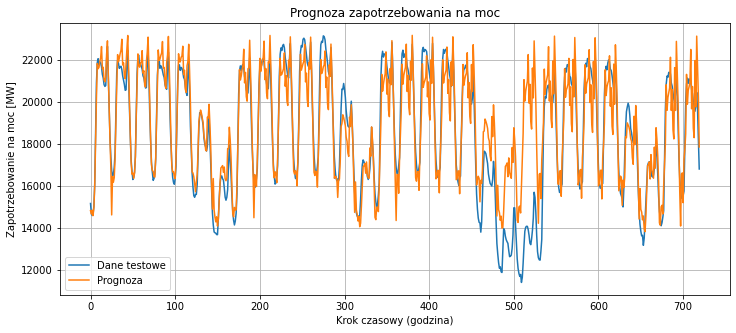

In [18]:
plt.figure(figsize=[12,5])
test_data.iloc[:sample].plot()
combined_forecasted_data.iloc[:sample].plot()
plt.legend(['Dane testowe', 'Prognoza'])
plt.title('Prognoza zapotrzebowania na moc')
plt.grid()
plt.xlabel('Krok czasowy (godzina)')
plt.ylabel('Zapotrzebowanie na moc [MW]')
plt.savefig('Prognoza zapotrzebowania na moc m24s7 bez regresorow2')